In [20]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl

In [21]:
plt.rc ('font', size = 10) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 10) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 10) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 20) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 10) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 10) #Schriftgröße der Legende

In [22]:
def pos(x):
    for i in range(len(data[0])):
        if data[0,i]>=x:
            return i
            break

FitFunktionen

In [23]:
def gaus1fit(von,bis,path,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],yerr=data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],data[1,vonarr:bisarr],yerr=data[2,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='--',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())


    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]),out_gaus




def gaus2fit(von,bis,path,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(data,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],yerr=data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],data[1,vonarr:bisarr],yerr=data[2,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='--',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]),out_gaus

Daten einlesen und Standartfehler as Fehler der Counts festlegen

<ErrorbarContainer object of 3 artists>

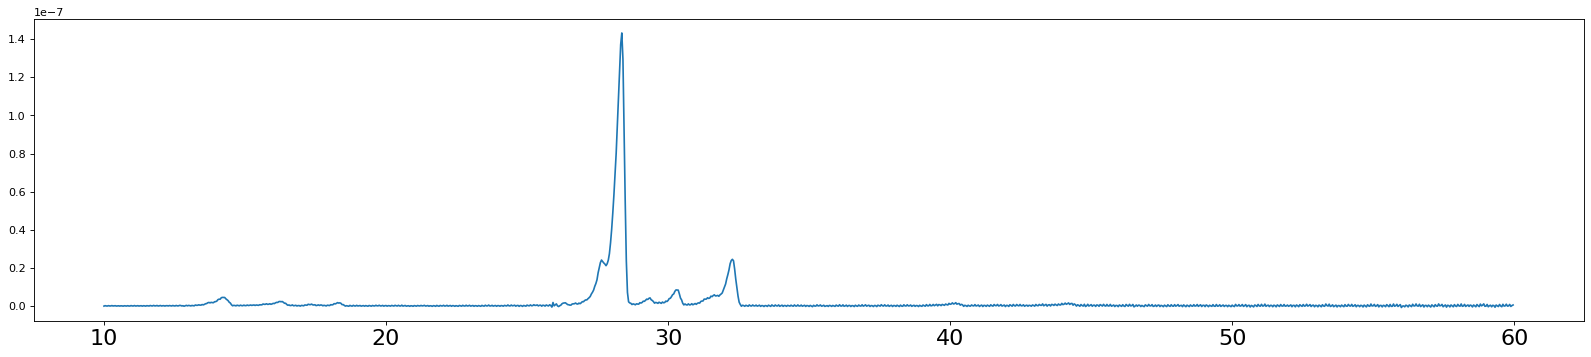

In [24]:
with open('Data/probe.csv', mode='r') as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        data = np.zeros((3,len(dataex[3])))
        data[0],data[1] = dataex[3],dataex[4]

with open('Data/restgas.csv', mode='r') as tf:
        datarestex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        datarest = np.zeros((3,len(datarestex[3])))
        datarest[0],datarest[1] = datarestex[3],datarestex[4]



#data
err = list(np.zeros(len(data[1])))
for i in range(len(err)):
    err[i] = ufloat(data[1,i],float(abs(data[1,i])*0.05))

#est
errrest = list(np.zeros(len(datarest[1])))
for i in range(len(errrest)):
    errrest[i] = ufloat(datarest[1,i],float(abs(datarest[1,i])*0.05))

for i in range(len(err)):
        err[i] = err[i]-errrest[i]

for i in range(len(data[1])):
    err[i] = err[i]*data[0,i]/28

for i in range(len(err)):
    data[1,i]=err[i].n
    data[2,i]=err[i].s





v = pos(10)
b = pos(60)

fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0,v:b],data[1,v:b],label = 'Data')
#plt.vlines(18.6,0,10e-9)

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 27
    # variables        = 3
    chi-square         = 9.4639e-18
    reduced chi-square = 3.9433e-19
    Akaike info crit   = -1141.36193
    Bayesian info crit = -1137.47442
[[Variables]]
    amplitude:  2.6190e-09 +/- 1.6235e-10 (6.20%) (init = 2.632457e-09)
    center:     14.1589882 +/- 0.01811562 (0.13%) (init = 14.2)
    sigma:      0.26220621 +/- 0.01993575 (7.60%) (init = 0.2)
    fwhm:       0.61744844 +/- 0.04694509 (7.60%) == '2.3548200*sigma'
    height:     3.9848e-09 +/- 2.3215e-10 (5.83%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.661
    C(center, sigma)     = 0.152
    C(amplitude, center) = 0.123


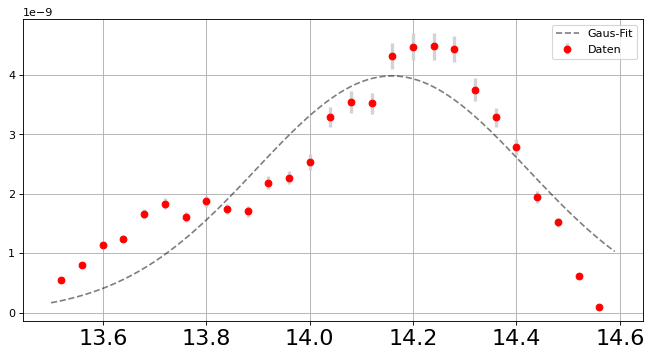

In [25]:
p14 = gaus1fit(13.5,14.6,'uluft_14.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 25
    # variables        = 3
    chi-square         = 3.2324e-18
    reduced chi-square = 1.4693e-19
    Akaike info crit   = -1081.30493
    Bayesian info crit = -1077.64830
[[Variables]]
    amplitude:  1.4442e-09 +/- 1.1928e-10 (8.26%) (init = 1.309674e-09)
    center:     16.1803310 +/- 0.02624390 (0.16%) (init = 16.23636)
    sigma:      0.29796213 +/- 0.03120165 (10.47%) (init = 0.22)
    fwhm:       0.70164718 +/- 0.07347428 (10.47%) == '2.3548200*sigma'
    height:     1.9336e-09 +/- 1.3650e-10 (7.06%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.740
    C(center, sigma)     = 0.256
    C(amplitude, center) = 0.232


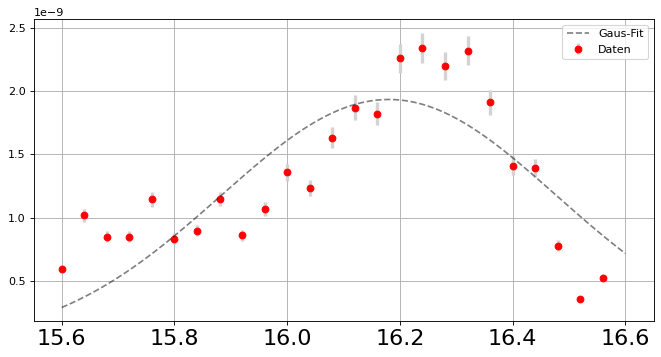

In [26]:
p16 = gaus1fit(15.6,16.6,'uluft_16.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 17
    # variables        = 3
    chi-square         = 3.5108e-19
    reduced chi-square = 2.5077e-20
    Akaike info crit   = -764.550269
    Bayesian info crit = -762.050629
[[Variables]]
    amplitude:  3.0796e-10 +/- 3.1376e-11 (10.19%) (init = 5.773545e-10)
    center:     17.3194691 +/- 0.01801911 (0.10%) (init = 17.31111)
    sigma:      0.15798086 +/- 0.01963351 (12.43%) (init = 0.18)
    fwhm:       0.37201650 +/- 0.04623339 (12.43%) == '2.3548200*sigma'
    height:     7.7768e-10 +/- 7.5186e-11 (9.67%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.651
    C(center, sigma)     = 0.137
    C(amplitude, center) = 0.109


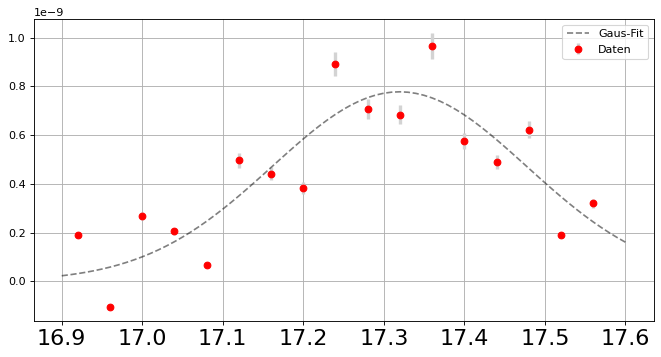

In [27]:
p17 = gaus1fit(16.9,17.6,'uluft_17.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 30
    # variables        = 3
    chi-square         = 1.8272e-18
    reduced chi-square = 6.7675e-20
    Akaike info crit   = -1321.34809
    Bayesian info crit = -1317.14450
[[Variables]]
    amplitude:  5.6888e-10 +/- 4.5124e-11 (7.93%) (init = 6.883756e-10)
    center:     18.2860980 +/- 0.01293729 (0.07%) (init = 18.28)
    sigma:      0.14130855 +/- 0.01295261 (9.17%) (init = 0.12)
    fwhm:       0.33275620 +/- 0.03050106 (9.17%) == '2.3548200*sigma'
    height:     1.6061e-09 +/- 1.2737e-10 (7.93%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.578


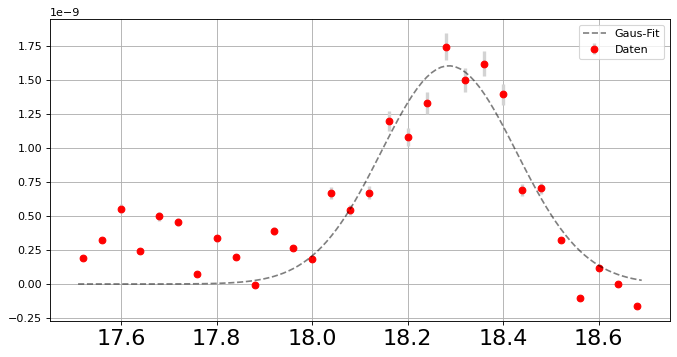

In [28]:
p18 = gaus1fit(17.51,18.7,'uluft_18.2')#,override=True,m1=18.21,m1min=18,m1max=18.5,s1=0.23,scale1=2.533068e-08,m2=17.21,m2min=17,m2max=17.5,s2=0.9,scale2=7.599203e-09)

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 290
    # data points      = 50
    # variables        = 6
    chi-square         = 2.7127e-15
    reduced chi-square = 6.1652e-17
    Akaike info crit   = -1860.64330
    Bayesian info crit = -1849.17116
[[Variables]]
    g1_amplitude:  4.4645e-08 +/- 3.1602e-09 (7.08%) (init = 1)
    g1_center:     28.3102733 +/- 0.00597014 (0.02%) (init = 28.3)
    g1_sigma:      0.13355068 +/- 0.00643727 (4.82%) (init = 1)
    g2_amplitude:  1.9996e-08 +/- 3.7872e-09 (18.94%) (init = 1)
    g2_center:     27.7500000 +/- 0.05791508 (0.21%) (init = 27.6)
    g2_sigma:      0.30501905 +/- 0.06536388 (21.43%) (init = 1)
    g1_fwhm:       0.31448781 +/- 0.01515862 (4.82%) == '2.3548200*g1_sigma'
    g1_height:     1.3336e-07 +/- 5.7496e-09 (4.31%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       0.71826496 +/- 0.15392018 (21.43%) =

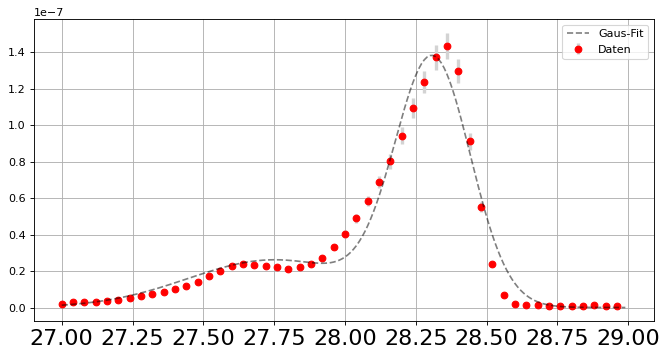

In [29]:
p28 = gaus2fit(27,29,'uluft_28.2',override=True,m1=28.3,m1min=28,m1max=28.4,m2=27.6,m2min=27.5,m2max=27.75)

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 18
    # variables        = 3
    chi-square         = 2.1621e-18
    reduced chi-square = 1.4414e-19
    Akaike info crit   = -778.185059
    Bayesian info crit = -775.513944
[[Variables]]
    amplitude:  2.0761e-09 +/- 1.5605e-10 (7.52%) (init = 1.736282e-09)
    center:     29.3142421 +/- 0.01945371 (0.07%) (init = 29.28)
    sigma:      0.23347801 +/- 0.02032583 (8.71%) (init = 0.16)
    fwhm:       0.54979868 +/- 0.04786367 (8.71%) == '2.3548200*sigma'
    height:     3.5474e-09 +/- 1.5292e-10 (4.31%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.869
    C(amplitude, center) = 0.684
    C(center, sigma)     = 0.666


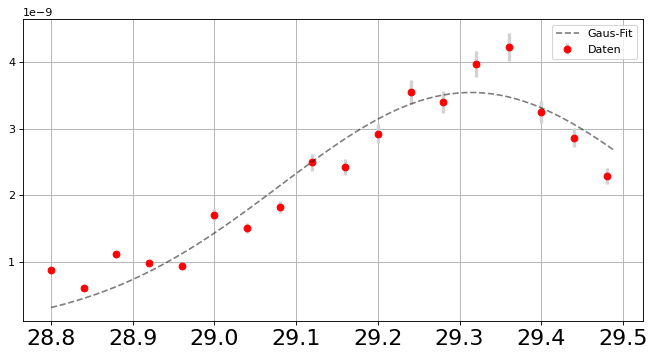

In [30]:
p29 = gaus1fit(28.8,29.5,'uluft_29.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 27
    # variables        = 3
    chi-square         = 3.6375e-17
    reduced chi-square = 1.5156e-18
    Akaike info crit   = -1105.00896
    Bayesian info crit = -1101.12145
[[Variables]]
    amplitude:  3.5245e-09 +/- 2.5537e-10 (7.25%) (init = 3.302567e-09)
    center:     30.2582651 +/- 0.01488008 (0.05%) (init = 30.26)
    sigma:      0.18193570 +/- 0.01587815 (8.73%) (init = 0.14)
    fwhm:       0.42842582 +/- 0.03739018 (8.73%) == '2.3548200*sigma'
    height:     7.7285e-09 +/- 5.4107e-10 (7.00%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.630
    C(center, sigma)    = 0.100


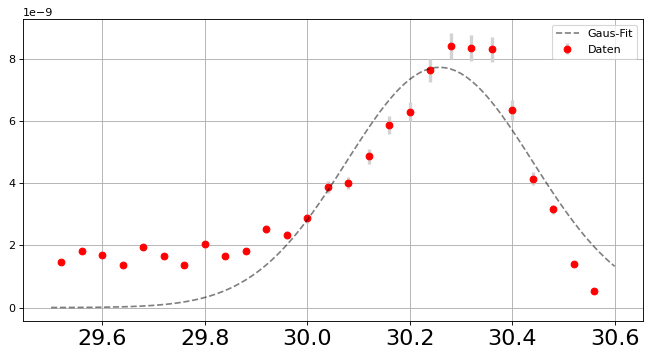

In [31]:
p30 = gaus1fit(29.5,30.6,'uluft_30.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 25
    # variables        = 3
    chi-square         = 1.9230e-18
    reduced chi-square = 8.7409e-20
    Akaike info crit   = -1094.28801
    Bayesian info crit = -1090.63139
[[Variables]]
    amplitude:  5.9484e-09 +/- 5.3254e-10 (8.95%) (init = 3.764192e-09)
    center:     31.7411116 +/- 0.04401640 (0.14%) (init = 31.52)
    sigma:      0.42941153 +/- 0.02925798 (6.81%) (init = 0.24)
    fwhm:       1.01118685 +/- 0.06889729 (6.81%) == '2.3548200*sigma'
    height:     5.5263e-09 +/- 1.7073e-10 (3.09%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = 0.970
    C(amplitude, sigma)  = 0.959
    C(center, sigma)     = 0.929


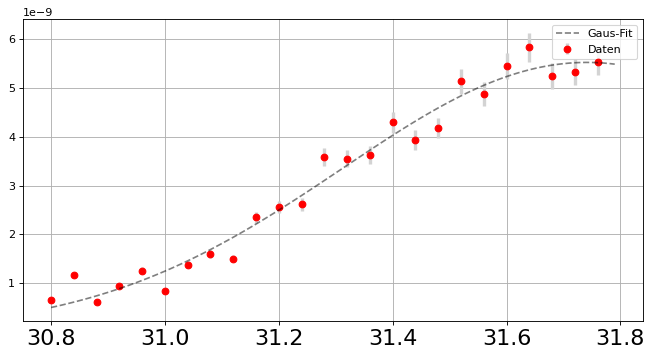

In [32]:
p31 = gaus1fit(30.8,31.8,'uluft_31.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 20
    # variables        = 3
    chi-square         = 1.1959e-16
    reduced chi-square = 7.0347e-18
    Akaike info crit   = -787.163994
    Bayesian info crit = -784.176797
[[Variables]]
    amplitude:  9.9325e-09 +/- 5.1689e-10 (5.20%) (init = 1.13738e-08)
    center:     32.2282235 +/- 0.01011052 (0.03%) (init = 32.24)
    sigma:      0.17044814 +/- 0.01049544 (6.16%) (init = 0.16)
    fwhm:       0.40137469 +/- 0.02471487 (6.16%) == '2.3548200*sigma'
    height:     2.3248e-08 +/- 1.1947e-09 (5.14%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.602


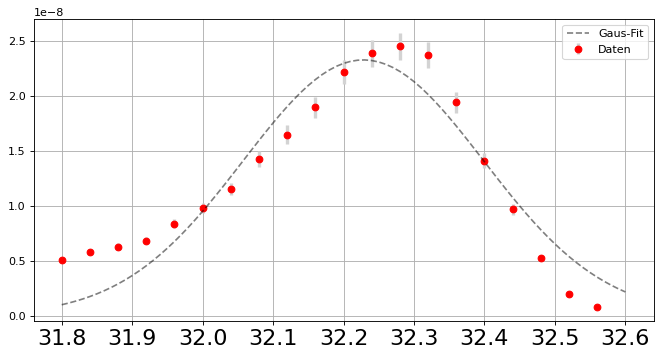

In [33]:
p32 = gaus1fit(31.8,32.6,'uluft_32.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 27
    # variables        = 3
    chi-square         = 2.9042e-18
    reduced chi-square = 1.2101e-19
    Akaike info crit   = -1173.25777
    Bayesian info crit = -1169.37026
[[Variables]]
    amplitude:  8.4634e-10 +/- 9.0487e-11 (10.69%) (init = 2.524963e-09)
    center:     40.0939868 +/- 0.03272377 (0.08%) (init = 40.06286)
    sigma:      0.27518656 +/- 0.03603908 (13.10%) (init = 0.44)
    fwhm:       0.64801482 +/- 0.08486554 (13.10%) == '2.3548200*sigma'
    height:     1.2270e-09 +/- 1.2545e-10 (10.22%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.647


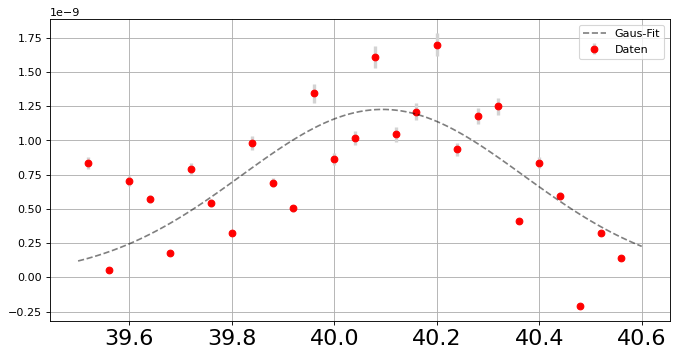

In [34]:
p40 = gaus1fit(39.5,40.6,'uluft_40.2')

/home/friedrichjahns/.local/lib/python3.10/site-packages/lmfit/model.py:990: UserWarning: The keyword argument yerr does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 50
    # variables        = 3
    chi-square         = 7.5538e-18
    reduced chi-square = 1.6072e-19
    Akaike info crit   = -2160.82488
    Bayesian info crit = -2155.08881
[[Variables]]
    amplitude:  1.1443e-09 +/- 1.3568e-10 (11.86%) (init = 5.119503e-09)
    center:     44.0378698 +/- 0.06496354 (0.15%) (init = 44.0087)
    sigma:      0.48789868 +/- 0.06994595 (14.34%) (init = 0.92)
    fwhm:       1.14891358 +/- 0.16471013 (14.34%) == '2.3548200*sigma'
    height:     9.3569e-10 +/- 1.0785e-10 (11.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.627


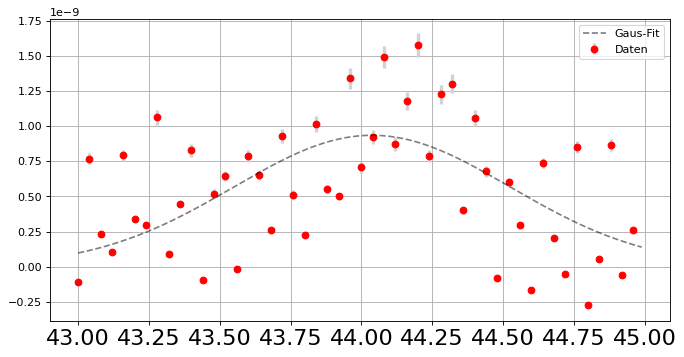

In [35]:
p44 = gaus1fit(43,45,'uluft_44.2')

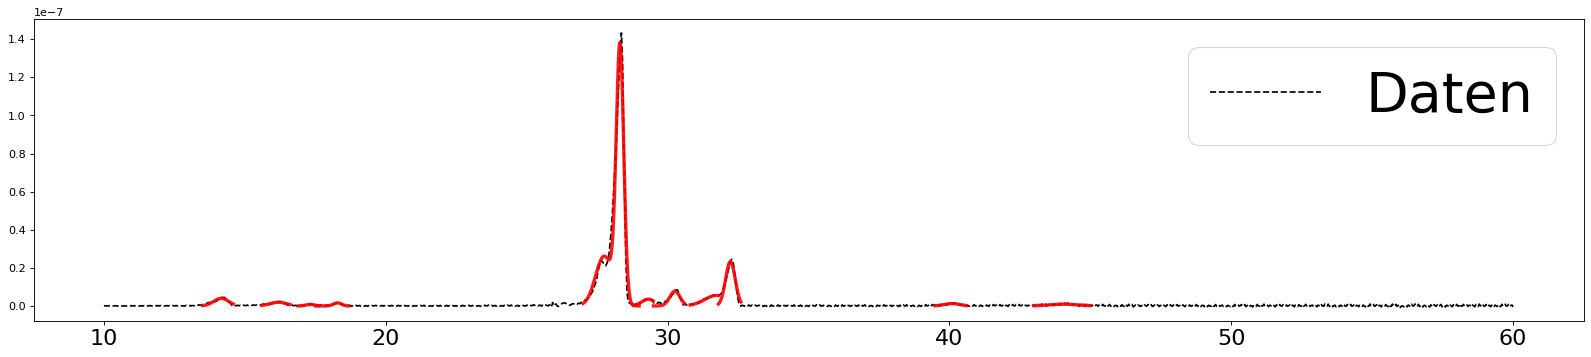

In [36]:
fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0],data[1],zorder=5,mfc='black',color='k',linestyle='--',label='Daten')

plt.plot(p14[0][0],p14[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p16[0][0],p16[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p17[0][0],p17[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p18[0][0],p18[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p28[0][0],p28[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p29[0][0],p29[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p30[0][0],p30[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p31[0][0],p31[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p32[0][0],p32[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p40[0][0],p40[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p44[0][0],p44[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)


plt.legend(fontsize=50)

In [40]:

amp14 = ufloat(p14[1].params['amplitude'].value,p14[1].params['amplitude'].stderr)
amp16 = ufloat(p16[1].params['amplitude'].value,p16[1].params['amplitude'].stderr)
amp17 = ufloat(p17[1].params['amplitude'].value,p17[1].params['amplitude'].stderr)
amp18 = ufloat(p18[1].params['amplitude'].value,p18[1].params['amplitude'].stderr)
amp28 = ufloat(p28[1].params['g1_amplitude'].value,p28[1].params['g1_amplitude'].stderr)
amp29 = ufloat(p29[1].params['amplitude'].value,p29[1].params['amplitude'].stderr)
amp30 = ufloat(p30[1].params['amplitude'].value,p30[1].params['amplitude'].stderr)
amp31 = ufloat(p31[1].params['amplitude'].value,p31[1].params['amplitude'].stderr)
amp32 = ufloat(p32[1].params['amplitude'].value,p32[1].params['amplitude'].stderr)
amp40 = ufloat(p40[1].params['amplitude'].value,p40[1].params['amplitude'].stderr)
amp44 = ufloat(p44[1].params['amplitude'].value,p44[1].params['amplitude'].stderr)

print('Poesitionm m/z')
print(ufloat(p14[1].params['center'].value,p14[1].params['center'].stderr))
print(ufloat(p16[1].params['center'].value,p16[1].params['center'].stderr))
print(ufloat(p17[1].params['center'].value,p17[1].params['center'].stderr))
print(ufloat(p18[1].params['center'].value,p18[1].params['center'].stderr))
print(ufloat(p28[1].params['g1_center'].value,p28[1].params['g1_center'].stderr))
print(ufloat(p29[1].params['center'].value,p29[1].params['center'].stderr))
print(ufloat(p30[1].params['center'].value,p30[1].params['center'].stderr))
print(ufloat(p31[1].params['center'].value,p31[1].params['center'].stderr))
print(ufloat(p32[1].params['center'].value,p32[1].params['center'].stderr))
print(ufloat(p40[1].params['center'].value,p40[1].params['center'].stderr))
print(ufloat(p44[1].params['center'].value,p44[1].params['center'].stderr))







print('Reihenfolge')
print('Methan')
print('Ammoniak')
print('Wasser')
print('Stickstoff')
print('Ethanol')
print('Sauerstoff')
print('Argon')
print('CO2')



print('Gesamtamplitude')
print(amp16*2.14/1.6)
print(amp17*1.9/1.3)
print(amp18*1.25/0.9)
print(amp28*1.8/1)
print(amp31*2.05/3.6)
print(amp32*1.11/0.86)
print(amp40*1.11/1.2)
print(amp44*1.38/1.4)



sum=0
for i in range(len(data[1])):
    sum+=ufloat(data[1,i],data[2,i])

print('Gesamtdruck')
print(sum)

print('Gesamtdruck/Gesamtamplituden')
print((amp16*2.14/1.6)/sum)
print((amp17*1.9/1.3)/sum)
print((amp18*1.25/0.9)/sum)
print((amp28*1.8/1)/sum)
print((amp31*2.05/3.6)/sum)
print((amp32*1.11/0.86)/sum)
print((amp40*1.11/1.2)/sum)
print((amp44*1.38/1.4)/sum)


Poesitionm m/z
14.159+/-0.018
16.180+/-0.026
17.319+/-0.018
18.286+/-0.013
28.310+/-0.006
29.314+/-0.019
30.258+/-0.015
31.74+/-0.04
32.228+/-0.010
40.094+/-0.033
44.04+/-0.06
Reihenfolge
Methan
Ammoniak
Wasser
Stickstoff
Ethanol
Sauerstoff
Argon
CO2
Gesamtamplitude
(1.93+/-0.16)e-09
(4.5+/-0.5)e-10
(7.9+/-0.6)e-10
(8.0+/-0.6)e-08
(3.39+/-0.30)e-09
(1.28+/-0.07)e-08
(7.8+/-0.8)e-10
(1.13+/-0.13)e-09
Gesamtdruck
(2.365+/-0.018)e-06
Gesamtdruck/Gesamtamplituden
0.00082+/-0.00007
0.000190+/-0.000019
0.000334+/-0.000027
0.0340+/-0.0024
0.00143+/-0.00013
0.00542+/-0.00029
0.000331+/-0.000035
0.00048+/-0.00006
